In [1]:
import numpy as np
import pandas as pd

import syndat
import dt_null_encoder

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# create test df with continuous, categorical, and date/time vars
n = 10000
x_norm = np.random.randn(n)
x_unif = np.random.rand(n)
x_categ = np.random.choice(['c1','c2','c3'], size=n, p=[0.2,0.3,0.5])
x_date = np.random.permutation(
    pd.date_range('2000-01-01', '2020-01-01', periods=n)
)

df = pd.DataFrame(
    {'x_norm':x_norm, 'x_unif':x_unif, 'x_categ':x_categ, 'x_date':x_date}
)

# convert dt to str to make the data more realistic
df['x_date'] = df['x_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

df.head()

,x_norm,x_unif,x_categ,x_date
0,-0.217438,0.977136,c3,2000-07-06
1,-0.175035,0.135394,c3,2014-03-27
2,1.520211,0.520152,c3,2007-05-19
3,0.726784,0.130162,c3,2008-10-09
4,-0.102943,0.023555,c2,2000-10-01


In [3]:
# inject NAs
n_na = int(len(df)/100)
for c in df.columns:
    df.loc[np.random.choice(np.arange(len(df)), n_na), c] = np.nan
df.isnull().sum()

x_norm     100
x_unif     100
x_categ    100
x_date     100
dtype: int64

In [4]:
cols = {'x_norm':'float', 'x_unif':'float', 'x_categ':'unord', 'x_date':'dt'}
# allowed types: quant, categ, ord, dt

# Synthetic data generation

In [5]:
# dt na encoding
df_orig = df.copy() # need df_orig for decoding dt nulls
df = dt_null_encoder.encode(df, cols)

In [6]:
df.isnull().sum()

x_norm     100
x_unif     100
x_categ    100
x_date       0
dtype: int64

## Multivariate density estimation and sampling

In [7]:
# the multivariate approach cannot hadnle NAs in int and float columns.
# impute NAs before calling syndat
df_imp = df.copy()

# replace NAs with 0 for now - can do "better", e.g., replace with median
df_imp[['x_norm','x_unif']] = df_imp[['x_norm','x_unif']] .fillna(0)

df_imp.isnull().sum()

x_norm       0
x_unif       0
x_categ    100
x_date       0
dtype: int64

In [8]:
sd = syndat.SynDat(df_imp, cols, multivariate=True, convert_dt=True)

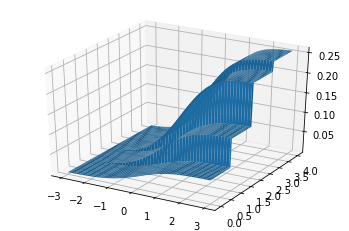

In [9]:
# plot mixture of continuous and categorical - CDF
x=np.linspace(-3,3,100)
y=np.linspace(0,4,100)
X, Y = np.meshgrid(x,y)
x_unif_samp = 0.5
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.cdf([x,x_unif_samp,y,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

Note that the fourth category corresponds to NAs

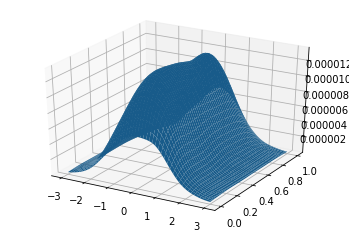

In [10]:
# plot continuous vars - PDF
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)

x_categ_samp = 2
x_date_samp = np.median(sd.df['x_date'])
z = np.array([sd.kde.pdf([x,y,x_categ_samp,x_date_samp]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)

In [11]:
# get synthetic data
df_samp = sd.get_sample(n=1000)

In [12]:
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.024824,0.514587,nan,1990-05-25
1,1.711368,0.852297,c3,1999-09-29
2,-0.518467,0.198161,c3,2004-03-06
3,0.101709,0.911193,c1,1994-01-02
4,-0.817334,0.165542,c3,2013-05-24


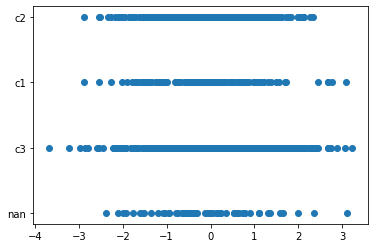

In [13]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

Note the addition of the nan category. If desired, NAs can be imputed before calling syndat

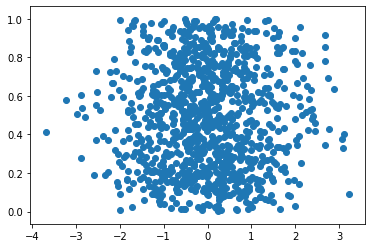

In [14]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

## Univariate density estimation and sampling

In [15]:
# unlike the multivariate approach, the univariate approach
# does not break if there are NAs in int and float cols
df.isnull().sum()

x_norm     100
x_unif     100
x_categ    100
x_date       0
dtype: int64

In [16]:
sd = syndat.SynDat(df, cols, multivariate=False, convert_dt=True)

/Users/mohammad.kayvanrad/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in greater
  x = x[np.logical_and(x > clip[0], x < clip[1])]
/Users/mohammad.kayvanrad/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in less
  x = x[np.logical_and(x > clip[0], x < clip[1])]


In [17]:
df_samp = sd.get_sample(n=1000)
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.785347,0.932041,c3,2007-09-13
1,-1.211327,0.263822,c3,2012-07-03
2,-0.855601,0.621652,c2,2003-04-13
3,0.048086,0.994317,c3,2013-07-10
4,0.791514,0.776273,c2,2004-10-25


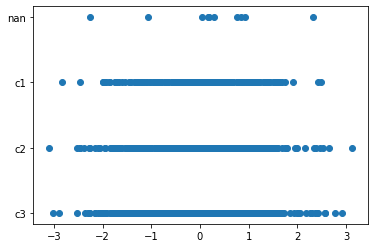

In [18]:
# plot sampled data - normal vs categorical
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_categ'])

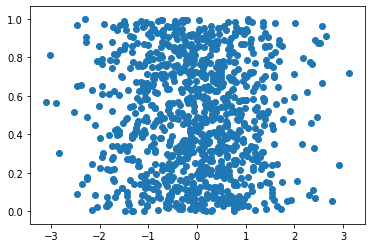

In [19]:
# plot sampled data - normal vs uniform
ax = plt.axes()
ax.scatter(df_samp['x_norm'],df_samp['x_unif'])

# Encoding categorical variables (e.g., for masking the real data)

In [23]:
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.785347,0.932041,c3,2007-09-13
1,-1.211327,0.263822,c3,2012-07-03
2,-0.855601,0.621652,c2,2003-04-13
3,0.048086,0.994317,c3,2013-07-10
4,0.791514,0.776273,c2,2004-10-25


In [31]:
import label_encoder

le_grp_dict = {
    'categ': [df_samp['x_categ']]
}

le_dict = {
    'categ': ['x_categ']
}

le = label_encoder.LabelEncoder(le_grp_dict)
df_samp = le.encode(df_samp, le_dict)
df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.785347,0.932041,2,2007-09-13
1,-1.211327,0.263822,2,2012-07-03
2,-0.855601,0.621652,1,2003-04-13
3,0.048086,0.994317,2,2013-07-10
4,0.791514,0.776273,1,2004-10-25


In [32]:
# adding prefix to the encoded categories
prefix_dict = {
    'x_categ': 'cat'
}

df_samp = le.add_prefix(df_samp, prefix_dict)

df_samp.head()

,x_norm,x_unif,x_categ,x_date
0,0.785347,0.932041,cat2,2007-09-13
1,-1.211327,0.263822,cat2,2012-07-03
2,-0.855601,0.621652,cat1,2003-04-13
3,0.048086,0.994317,cat2,2013-07-10
4,0.791514,0.776273,cat1,2004-10-25
